In [18]:
using Plots
using XLSX
using YAML
using CSV
using DataFrames
using Statistics
using StatsBase
using Dates

# Import of ARERA data 

In [35]:
# Selection of size of ARERA_profiles_residential
size_ARERA = "1_5_a_3"
#size_ARERA = "3_a_4_5"
size_ARERA = "4_5_a_6"

# Define the file path
general_path = @__DIR__
relative_path_GSE = "../data/ARERA/dati prelievo orario per provincia$size_ARERA anno 2022.xlsx"
file_GSE= joinpath(general_path,relative_path_GSE)

# Read data from the first sheet of the Excel file
ARERA_profiles= DataFrame(XLSX.readtable(file_GSE,"dati prelievo orario per provin"));

In [36]:
# Filtra i dati per provincia
provincia = "Roma"

# Filtra i dati per tipologia di mercato "Mercato Libero","Servizio di Maggior Tutela" o "Tutti"
tipologia_mercato = "Tutti"

# Giorni della settimana
giorni = ["SAB", "DOM", "Giorno_feriale"]

# Filtra i dati per provincia
ARERA_profiles = ARERA_profiles[(ARERA_profiles[!, "Provincia"] .== provincia) .& (ARERA_profiles[!,"Tipo Mercato"] .== tipologia_mercato), :]

# Modifica Orario colonna
ARERA_profiles[!,"Orario"] = replace.(ARERA_profiles[!,"Orario"], "Ora" => "")

# Rename the columns
rename!(ARERA_profiles, Dict("Prelievo medio Orario Provinciale (kWh)" => "Valore_orario"))
rename!(ARERA_profiles, Dict("Working Day" => "Giorno"))

# Show first 15 rows of the DataFrame
show(ARERA_profiles)

2808×8 DataFrame
  Row │ Anno mese   Provincia  Tipo Mercato  Classe potenza            Residen ⋯
      │ Any         Any        Any           Any                       Any     ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen ⋯
    2 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen
    3 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen
    4 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen
    5 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen ⋯
    6 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen
    7 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen
    8 │ 2022-01-01  Roma       Tutti         4.5<potenza_impegnata<=6  Residen
  ⋮   │     ⋮           ⋮           ⋮                   ⋮                  ⋮   ⋱
 2802 │ 2022        Rom

# Plots

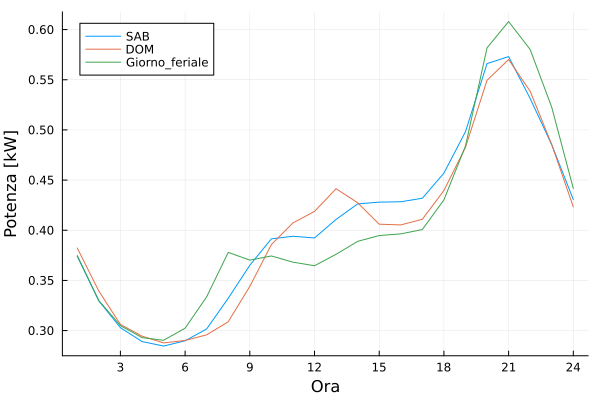

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\ARERA\\4_5_a_6\\ARERA_statistics.png"

In [38]:
# Filtra i dati per "Anno mese" == 2022
yearly_data = ARERA_profiles[ARERA_profiles[!, "Anno mese"] .== 2022, :]

# Raggruppa i dati per "Giorno"
grouped_data = groupby(yearly_data, [:Giorno, :Orario])

# Calcola la media per ogni ora in ogni gruppo
average_curve = combine(grouped_data, :Valore_orario => mean => :Valore_medio)
median_curve = combine(grouped_data, :Valore_orario => median => :Valore_mediano)

# Crea un nuovo plot
p0 = plot(xlab = "Ora", ylab = "Potenza [kW]")

p1 = deepcopy(p0)

# Plotta i dati
for giorno in giorni
    subset1 = average_curve[average_curve.Giorno .== giorno, :]
    #subset2 = median_curve[median_curve.Giorno .== giorno, :]
    plot!(p1, subset1.Orario, subset1.Valore_medio, label = giorno)
    #plot!(p0, subset2.Orario, subset2.Valore_mediano, label = giorno, linestyle = :dash)
end

# Mostra il plot
display(p1)

# Salva il plot
savefig(joinpath(general_path,"../results/Immagini/ARERA/$size_ARERA/ARERA_statistics.png"))

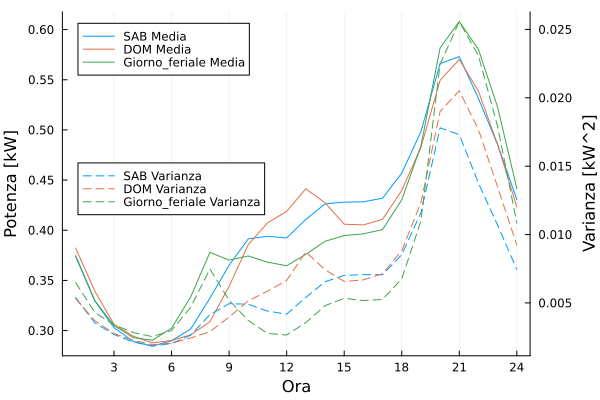

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\ARERA\\4_5_a_6\\ARERA_statistics_var.png"

In [57]:
# Filtra i dati per "Anno mese" == 2022
yearly_data = ARERA_profiles[ARERA_profiles[!, "Anno mese"] .== 2022, :]

# Raggruppa i dati per "Giorno"
grouped_data = groupby(yearly_data, [:Giorno, :Orario])

# Calcola la media per ogni ora in ogni gruppo
average_curve = combine(grouped_data, :Valore_orario => mean => :Valore_medio)
var_curve = combine(grouped_data, :Valore_orario => var => :Varianza)

p1_1 = deepcopy(p0)

# Plotta i dati
for giorno in giorni
    subset1 = average_curve[average_curve.Giorno .== giorno, :]
    plot!(p1_1, subset1.Orario, subset1.Valore_medio, label = " $giorno Media")
end

p_secondary = twinx()
for giorno in giorni
    subset = var_curve[var_curve.Giorno .== giorno, :]
    plot!(p_secondary, subset.Orario, subset.Varianza, label = " $giorno Varianza", legend = :left, linestyle = :dash, ylabel = "Varianza [kW^2]")
end

# Mostra il plot
display(p1_1)

# Salva il plot
savefig(joinpath(general_path,"../results/Immagini/ARERA/$size_ARERA/ARERA_statistics_var.png"))

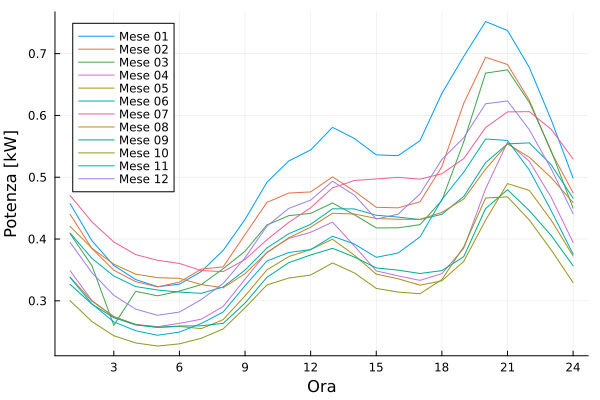

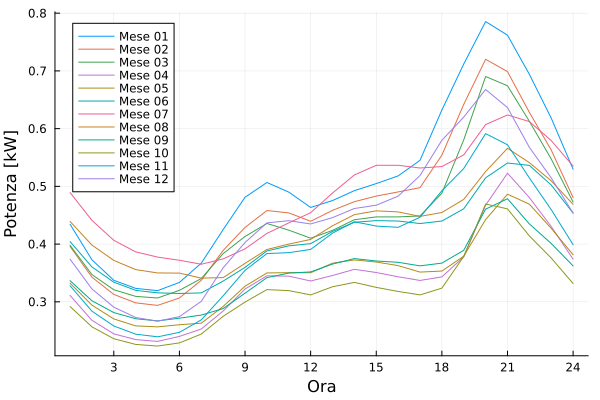

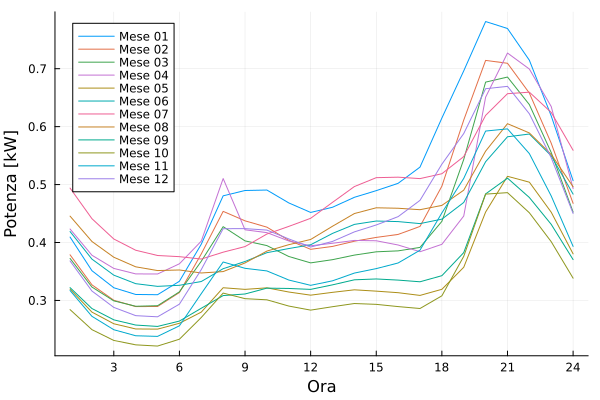

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\ARERA\\4_5_a_6\\ARERA_monthly_weekday.png"

In [72]:
monthly_ARERA = ARERA_profiles[ARERA_profiles[!, "Anno mese"] .!= 2022, :]

# Crea tre nuovi plot
p_DOM = deepcopy(p0)
p_SAB = deepcopy(p0)
p_weekday = deepcopy(p0)

# Plotta i dati
for mese in unique(monthly_ARERA[!,"Anno mese"])
    # Estrai la stringa tra "-" e "-"
    label_month = split(Dates.format(mese, "yyyy-mm"), "-")[2]
    subset = monthly_ARERA[monthly_ARERA[!,"Anno mese"] .== mese, :]
    grouped_data = groupby(subset, [:Giorno, :Orario])
    average_curve = combine(grouped_data, :Valore_orario => mean => :Valore_medio)
    variance_curve = combine(grouped_data, :Valore_orario => var => :Varianza)
    for giorno in giorni
        subset = average_curve[average_curve.Giorno .== giorno, :]
        if giorno == "DOM"
            plot!(p_DOM, subset.Orario, subset.Valore_medio, label = "Mese $label_month")
        elseif giorno == "SAB"
            plot!(p_SAB, subset.Orario, subset.Valore_medio, label = "Mese $label_month")
        else
            plot!(p_weekday, subset.Orario, subset.Valore_medio, label = "Mese $label_month")
        end
    end
end

# Mostra i plot
display(p_DOM)
display(p_SAB)
display(p_weekday)

# Salva i plot
savefig(p_DOM, joinpath(general_path,"../results/Immagini/ARERA/$size_ARERA/ARERA_montly_DOM.png"))
savefig(p_SAB, joinpath(general_path,"../results//Immagini/ARERA/$size_ARERA/ARERA_monthly_SAB.png"))
savefig(p_weekday, joinpath(general_path,"../results//Immagini/ARERA/$size_ARERA/ARERA_monthly_weekday.png"))

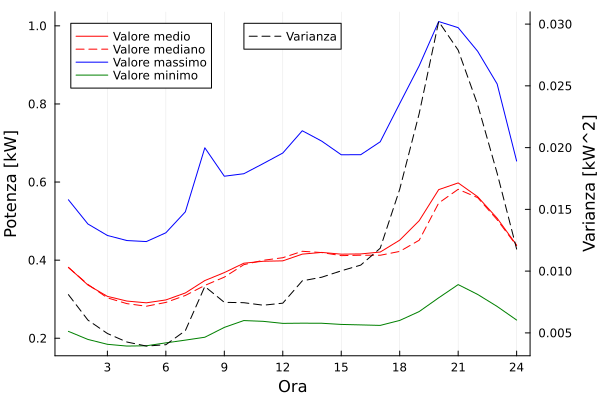

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\ARERA\\4_5_a_6\\ARERA_domestic_min_avr_max_var.png"

In [71]:
monthly_ARERA = ARERA_profiles[ARERA_profiles[!, "Anno mese"] .!= 2022, :]

# Assumendo che "Ora" sia una colonna in monthly_ARERA e che tu voglia calcolare la media di una colonna chiamata "Valore"
grouped = groupby(monthly_ARERA, :Orario)
average_curve = combine(grouped, :Valore_orario => mean => :Valore_medio)
maximum_curve = combine(grouped, :Valore_orario => maximum => :Valore_massimo)
minimum_curve = combine(grouped, :Valore_orario => minimum => :Valore_minimo)
median_curve = combine(grouped, :Valore_orario => median => :Valore_mediano)
variance_curve = combine(grouped, :Valore_orario => var => :Varianza)

# Create base plot
p2 = deepcopy(p0)

# Plot the data
plot!(p2, average_curve.Orario, average_curve.Valore_medio, label = "Valore medio", color = :red)
plot!(p2, median_curve.Orario, median_curve.Valore_mediano, label = "Valore mediano", color = :red, linestyle = :dash)
plot!(p2, maximum_curve.Orario, maximum_curve.Valore_massimo, label = "Valore massimo", color = :blue)
plot!(p2, minimum_curve.Orario, minimum_curve.Valore_minimo, label = "Valore minimo", color = :green)
p_secondary = twinx()
plot!(p_secondary, variance_curve.Orario, variance_curve.Varianza, label = "Varianza", color = :black, legend = :top, linestyle = :dash, ylabel = "Varianza [kW^2]")

# Show the plot
display(p2)

# Save the plot
savefig(joinpath(general_path,"../results/Immagini/ARERA/$size_ARERA/ARERA_domestic_min_avr_max_var.png"))

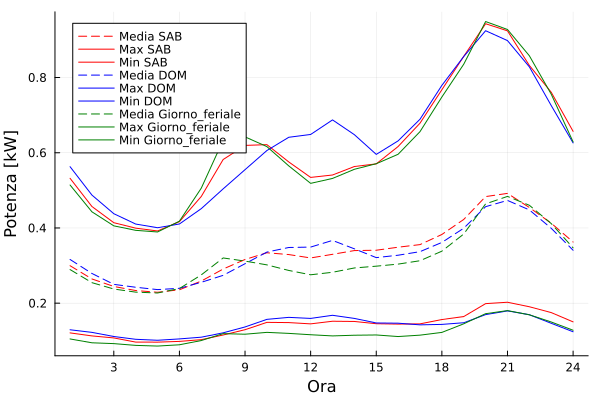

"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\results\\Immagini\\ARERA\\4_5_a_6\\ARERA_min_max_avr_week.png"

In [24]:
monthly_ARERA = ARERA_profiles[ARERA_profiles[!, "Anno mese"] .!= 2022, :]

# Crea tre nuovi plot
p_min_max_average = plot(xlab = "Ora", ylab = "Potenza [kW]")

# Crea un array di colori
color_map = [:red, :blue, :green]

# Plotta i dati
for (i, giorno) in enumerate(giorni)
    subset = monthly_ARERA[monthly_ARERA.Giorno .== giorno, :]
    grouped = groupby(subset, :Orario)
    average_curve = combine(grouped, :Valore_orario => mean => :Valore_medio)
    maximum_curve = combine(grouped, :Valore_orario => maximum => :Valore_massimo)
    minimum_curve = combine(grouped, :Valore_orario => minimum => :Valore_minimo)
    plot!(p_min_max_average, average_curve.Orario, average_curve.Valore_medio, label = "Media $giorno", linecolor = color_map[i], line = :dash)
    plot!(p_min_max_average, maximum_curve.Orario, maximum_curve.Valore_massimo, label = "Max $giorno", linecolor = color_map[i])
    plot!(p_min_max_average, minimum_curve.Orario, minimum_curve.Valore_minimo, label = "Min $giorno", linecolor = color_map[i])
end

# Mostra i plot
display(p_min_max_average)

# Salva i plot
savefig(p_min_max_average, joinpath(general_path,"../results/Immagini/ARERA/$size_ARERA/ARERA_min_max_avr_week.png"))

# Export results

In [25]:
# Create a vector of 8761 elements with values filled with the correspondig value of ARERA profiles when there is corresponsance between months, days and hours
df_ARERA = DataFrame(Mese = Int[], Giorno = Int[], Ora = Int[], Valore_orario = Float64[])

# Choose the year
year = 2021

ARERA_profiles[!,"Mese"] = Dates.month.(ARERA_profiles[!, "Anno mese"])

for mese in unique(ARERA_profiles[!,"Mese"])
    for giorno in 1:Dates.daysinmonth(Date(year, mese))
        if Dates.dayofweek(Date(year, mese, giorno)) < 6
            for ora in 1:24
                subset = ARERA_profiles[(ARERA_profiles[!,"Mese"] .== mese) .& (ARERA_profiles[!,"Giorno"] .== "Giorno_feriale") .& (ARERA_profiles[!,"Orario"] .== string(ora)), :]
                if nrow(subset) > 0
                    push!(df_ARERA, [mese, giorno, ora, subset[1, "Valore_orario"]])
                end
            end
        elseif Dates.dayofweek(Date(year, mese, giorno)) == 6
            for ora in 1:24
                subset = ARERA_profiles[(ARERA_profiles[!,"Mese"] .== mese) .& (ARERA_profiles[!,"Giorno"] .== "SAB") .& (ARERA_profiles[!,"Orario"] .== string(ora)), :]
                if nrow(subset) > 0
                    push!(df_ARERA, [mese, giorno, ora, subset[1, "Valore_orario"]])
                end
            end
        else
            for ora in 1:24
                subset = ARERA_profiles[(ARERA_profiles[!,"Mese"] .== mese) .& (ARERA_profiles[!,"Giorno"] .== "DOM") .& (ARERA_profiles[!,"Orario"] .== string(ora)), :]
                if nrow(subset) > 0
                    push!(df_ARERA, [mese, giorno, ora, subset[1, "Valore_orario"]])
                end  
            end
        end
    end
end

#Save the data
CSV.write(joinpath(general_path,"../results/Dati/ARERA_profiles$size_ARERA.csv"), df_ARERA)


"c:\\Users\\tomma\\OneDrive\\Desktop\\test\\ECPreprocessing\\src\\../results/Dati/ARERA_profiles4_5_a_6.csv"